/home/liyiming/anaconda3/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1699: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


Finished reading the train set of Leaves Dataset (18353 samples found)
Training for fold 0/10...


/home/liyiming/anaconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
  0%|          | 0/130 [00:00<?, ?it/s]

Epoch 0/100 training...


  0%|          | 0/130 [00:05<?, ?it/s]


KeyError: 'verbose'

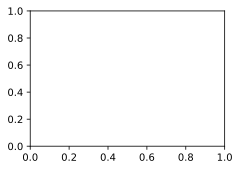

In [1]:
from train import train

args = {
    'batch_size': 128,
    'model': 'seresnext50',
    'freeze': False,
    'eval_all': True,
    'data_root': '../dataset/classify-leaves',
    'val_ratio': 0.1,
    'fold': 10,
    'lr': 0.01,
    'epoch': 100,
    'resume': False,
    'verbose': True
}
class AttributeDict(dict):
    __slots__ = () 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
args = AttributeDict(args)

train(args)